# **Hard Clustering: Análisis de Patrones de Movimiento con K-Means 📊**

<span style="font-size: 1.5rem;">

🎓 **Universidad:** Fundación Universitaria Konrad Lorenz

</span>

<span style="font-size: 1.25rem;">

🏫 **Facultad:** Facultad de Matemáticas e Ingenierías

📖 **Curso:** Introducción a Big Data

</span>

<span style="font-size: 1.5rem;">

**🧑‍💻 Integrantes:**

</span>

- Ángel Stiven Pinzón Sánchez - 506221100
- Andrea Valentina Cubillos Pinto - 506231711
- Martín Alexander Ramos Yampufe - 506251051


## **Introducción**


**El Reconocimiento de Actividad Humana (HAR)** es una técnica ampliamente
utilizada en el monitoreo de la salud, el análisis del rendimiento deportivo y
el seguimiento de la actividad física mediante dispositivos portátiles. Estos
sistemas suelen basarse en datos obtenidos de acelerómetros y giroscopios, los
cuales permiten detectar patrones de movimiento y clasificar actividades.

Uno de los principales desafíos en HAR es la detección de inactividad prolongada
en condiciones de vida libre, un aspecto clave para la prevención de
enfermedades asociadas al sedentarismo. Sin embargo, la mayoría de los estudios
actuales dependen de modelos supervisados, los cuales requieren datos
etiquetados, lo que puede ser un proceso costoso y propenso a errores.

Para abordar esta limitación, en este proyecto aplicaremos K-Means, un algoritmo
de aprendizaje no supervisado, para analizar datos de acelerómetros y detectar
segmentos de tiempo con baja actividad física. Este enfoque nos permitirá
identificar patrones de inactividad sin necesidad de etiquetas previas,
facilitando su aplicación en el monitoreo de la salud y la detección temprana de
conductas sedentarias.


## **Objetivos**


El objetivo de este análisis es identificar patrones de movimiento a partir de
datos de acelerómetros, explorando relaciones entre variables y reduciendo la
dimensionalidad de los datos para facilitar su agrupamiento mediante
**K-Means**. Esto permitirá detectar segmentos de baja actividad física y
evaluar su utilidad en el Reconocimiento de Actividad Humana (HAR) para prevenir
enfermedades relacionadas con el sedentarismo.


## **Preprocesamiento de datos**


In [ ]:
import io
import math
import zipfile
from inspect import cleandoc
from pathlib import Path
from typing import Final

import joblib
import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import requests
import seaborn as sns
from IPython.display import Markdown
from scipy import stats
from scipy.stats import zscore
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import StandardScaler
from sklearn.inspection import permutation_importance
from sklearn.manifold import TSNE
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    accuracy_score,
    classification_report,
    confusion_matrix,
)
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential

In [2]:
dataset_url: Final[str] = (
    "https://drive.usercontent.google.com/download?id=1pawtHobYPmvHLKKJfbg12fqkMdG5rlkL&export=download&authuser=0&confirm=t&uuid=c5110138-278c-4dc3-9be0-a11aeaefd54d&at=ALoNOgn9aAhEQRUpJf90DRNzLwiP%3A1748493341099"
)

In [3]:
response = requests.get(
    dataset_url,
    timeout=10,
)

# Delete the data directory if it already exists
data_dir = Path("./data")


def remove_file_or_directory(file_or_directory: Path) -> None:
    """Elimina un archivo o carpeta de forma recursiva."""
    if file_or_directory.is_dir():
        for file in file_or_directory.iterdir():
            remove_file_or_directory(file)
        file_or_directory.rmdir()
    else:
        file_or_directory.unlink()


if data_dir.exists():
    remove_file_or_directory(data_dir)


with zipfile.ZipFile(io.BytesIO(response.content)) as zip_file:
    zip_file.extractall("./data")

In [4]:
path = Path("./data/harth")
all_files = path.glob("S0*.csv")

df_list = []
for file in all_files:
    temp_df = pl.read_csv(file)

    # Eliminamos la columna 'Unnamed: 0' si existe y index
    if "index" in temp_df.columns:
        temp_df = temp_df.drop("index")
    if "" in temp_df.columns:
        temp_df = temp_df.drop("")

    display(
        Markdown(f"Archivo: {file}, Tamaño: {temp_df.shape}")
    )  # Imprime el tamaño de cada archivo
    df_list.append(temp_df)

display(
    Markdown(
        f"Número total de filas en todos los archivos: {sum(df.shape[0] for df in df_list)}"
    )
)

# Combina los DataFrames
df: pl.DataFrame = pl.concat(
    df_list,
)

# Convierte la columna timestamp a tipo datetime
df = df.with_columns(
    pl.col("timestamp").str.strptime(
        pl.Datetime, "%Y-%m-%d %H:%M:%S%.f", strict=False
    )
)

# Verifica el contenido del DataFrame después de cargar los archivos
display(
    Markdown("Contenido del DataFrame después de cargar los archivos:"),
    df.head(),
    df.describe(),
    df.schema.to_frame(),
    Markdown(f"{df.estimated_size() / (1024 * 1024):.2f} MB"),
)

Archivo: data\harth\S006.csv, Tamaño: (408709, 8)

Archivo: data\harth\S008.csv, Tamaño: (418989, 8)

Archivo: data\harth\S009.csv, Tamaño: (154464, 8)

Archivo: data\harth\S010.csv, Tamaño: (351649, 8)

Archivo: data\harth\S012.csv, Tamaño: (382414, 8)

Archivo: data\harth\S013.csv, Tamaño: (369077, 8)

Archivo: data\harth\S014.csv, Tamaño: (366487, 8)

Archivo: data\harth\S015.csv, Tamaño: (418392, 8)

Archivo: data\harth\S016.csv, Tamaño: (355418, 8)

Archivo: data\harth\S017.csv, Tamaño: (366609, 8)

Archivo: data\harth\S018.csv, Tamaño: (322271, 8)

Archivo: data\harth\S019.csv, Tamaño: (297945, 8)

Archivo: data\harth\S020.csv, Tamaño: (371496, 8)

Archivo: data\harth\S021.csv, Tamaño: (302247, 8)

Archivo: data\harth\S022.csv, Tamaño: (337602, 8)

Archivo: data\harth\S023.csv, Tamaño: (137646, 8)

Archivo: data\harth\S024.csv, Tamaño: (170534, 8)

Archivo: data\harth\S025.csv, Tamaño: (231729, 8)

Archivo: data\harth\S026.csv, Tamaño: (195172, 8)

Archivo: data\harth\S027.csv, Tamaño: (158584, 8)

Archivo: data\harth\S028.csv, Tamaño: (165178, 8)

Archivo: data\harth\S029.csv, Tamaño: (178716, 8)

Número total de filas en todos los archivos: 6461328

Contenido del DataFrame después de cargar los archivos:

timestamp,back_x,back_y,back_z,thigh_x,thigh_y,thigh_z,label
datetime[μs],f64,f64,f64,f64,f64,f64,i64
2019-01-12 00:00:00,-0.760242,0.29957,0.46857,-5.092732,-0.298644,0.709439,6
2019-01-12 00:00:00.010,-0.530138,0.28188,0.319987,0.900547,0.286944,0.340309,6
2019-01-12 00:00:00.020,-1.170922,0.186353,-0.16701,-0.035442,-0.078423,-0.515212,6
2019-01-12 00:00:00.030,-0.648772,0.016579,-0.054284,-1.554248,-0.950978,-0.22114,6
2019-01-12 00:00:00.040,-0.355071,-0.051831,-0.113419,-0.547471,0.140903,-0.653782,6


statistic,timestamp,back_x,back_y,back_z,thigh_x,thigh_y,thigh_z,label
str,str,f64,f64,f64,f64,f64,f64,f64
"""count""","""6461328""",6.461328e6,6.461328e6,6.461328e6,6.461328e6,6.461328e6,6.461328e6,6.461328e6
"""null_count""","""0""",0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""","""2012-02-20 18:20:58.805005""",-0.884957,-0.013261,-0.169378,-0.594888,0.020877,0.374916,6.783833
"""std""",null,0.377592,0.231171,0.364738,0.626347,0.388451,0.736098,11.432381
"""min""","""2000-01-01 00:00:00""",-8.0,-4.307617,-6.574463,-8.0,-7.997314,-8.0,1.0
"""25%""","""2000-01-01 01:23:47.680000""",-1.002393,-0.083129,-0.37207,-0.974211,-0.100087,-0.155714,3.0
"""50%""","""2019-01-12 00:12:46.760000""",-0.9749,0.002594,-0.137451,-0.421731,0.032629,0.700439,7.0
"""75%""","""2019-01-12 00:49:20.500000""",-0.812303,0.07251,0.046473,-0.167876,0.154951,0.948675,7.0
"""max""","""2019-01-12 02:23:36.720000""",2.291708,6.491943,4.909483,7.999756,7.999756,8.406235,140.0


timestamp,back_x,back_y,back_z,thigh_x,thigh_y,thigh_z,label
datetime[μs],f64,f64,f64,f64,f64,f64,i64


394.37 MB

In [5]:
display(Markdown("Número de valores nulos en cada columna:"), df.null_count())

Número de valores nulos en cada columna:

timestamp,back_x,back_y,back_z,thigh_x,thigh_y,thigh_z,label
u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,0,0,0,0,0


In [6]:
display(Markdown(f"Tamaño antes de eliminar nulos: {df.shape}"))

df = df.drop_nulls()  # Eliminar filas con valores nulos

Markdown(f"Tamaño después de eliminar nulos: {df.shape}")

Tamaño antes de eliminar nulos: (6461328, 8)

Tamaño después de eliminar nulos: (6461328, 8)

In [7]:
quantitative_cols = [
    "back_x",
    "back_y",
    "back_z",
    "thigh_x",
    "thigh_y",
    "thigh_z",
]

display(
    Markdown(
        cleandoc(f"""
            Tamaño del DataFrame antes de la normalización: {df.shape}

            Contenido del DataFrame antes de la normalización:
        """),
    ),
    df.head(),
)

# Normalización
if all(col in df.columns for col in quantitative_cols):
    if df[quantitative_cols].shape[0] > 0:
        scaler = StandardScaler()
        df[quantitative_cols] = scaler.fit_transform(
            df[quantitative_cols].to_arrow()
        )
    else:
        display(Markdown("Las columnas seleccionadas están vacías."))
else:
    display(Markdown("Una o más columnas no existen en el DataFrame."))

Tamaño del DataFrame antes de la normalización: (6461328, 8)

Contenido del DataFrame antes de la normalización:

timestamp,back_x,back_y,back_z,thigh_x,thigh_y,thigh_z,label
datetime[μs],f64,f64,f64,f64,f64,f64,i64
2019-01-12 00:00:00,-0.760242,0.29957,0.46857,-5.092732,-0.298644,0.709439,6
2019-01-12 00:00:00.010,-0.530138,0.28188,0.319987,0.900547,0.286944,0.340309,6
2019-01-12 00:00:00.020,-1.170922,0.186353,-0.16701,-0.035442,-0.078423,-0.515212,6
2019-01-12 00:00:00.030,-0.648772,0.016579,-0.054284,-1.554248,-0.950978,-0.22114,6
2019-01-12 00:00:00.040,-0.355071,-0.051831,-0.113419,-0.547471,0.140903,-0.653782,6


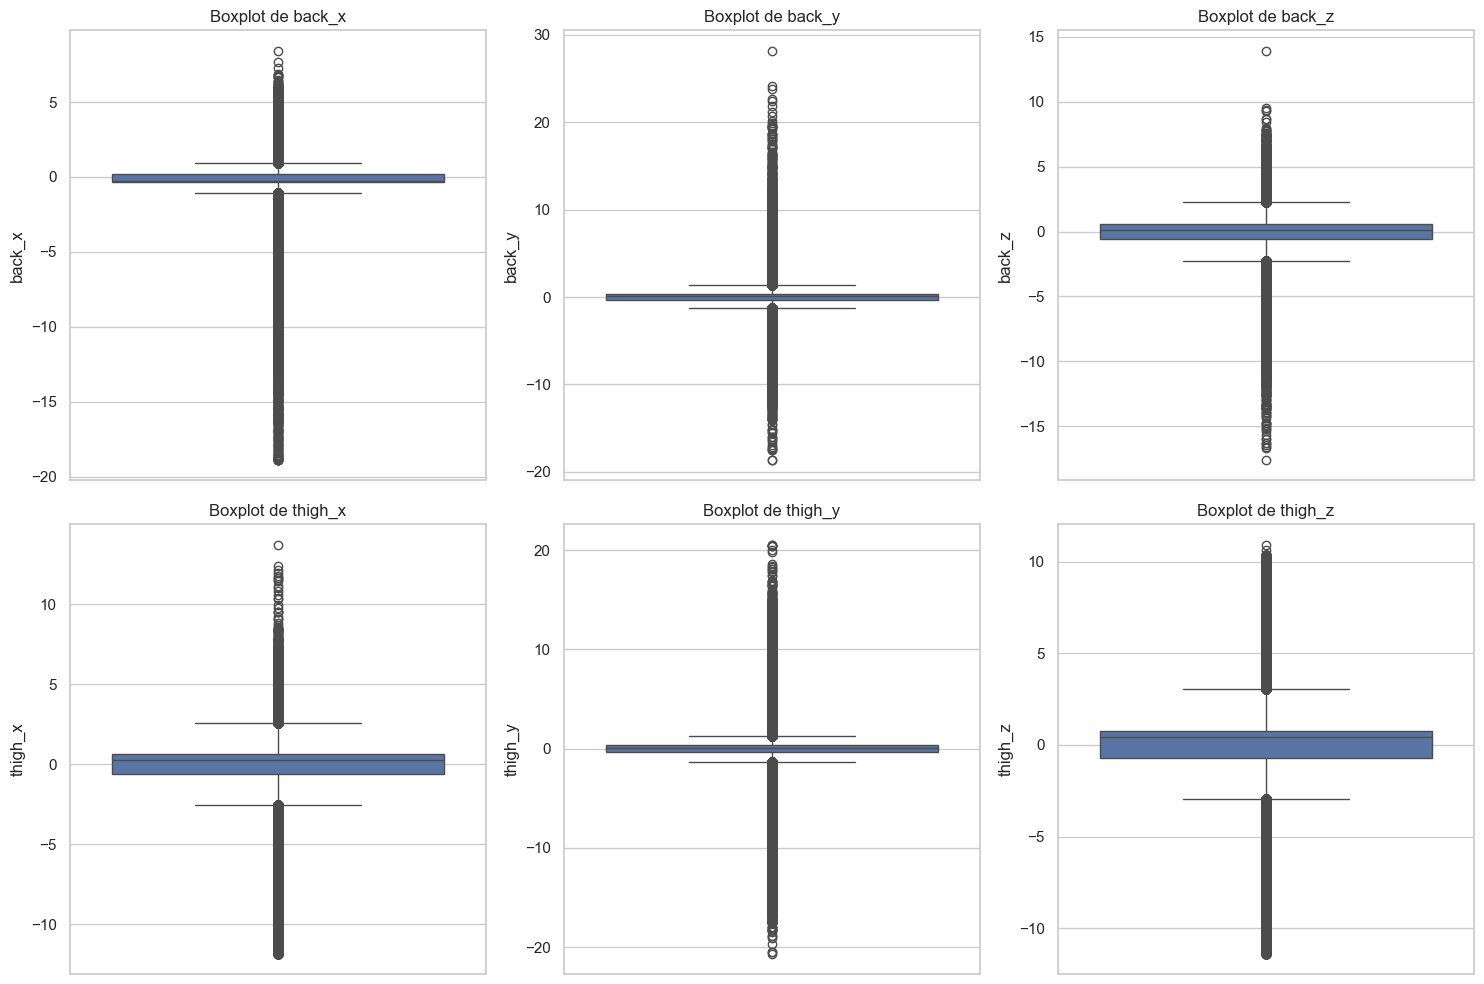

Número de outliers detectados por Z-Score: $507343$

timestamp,back_x,back_y,back_z,thigh_x,thigh_y,thigh_z,label
datetime[μs],f64,f64,f64,f64,f64,f64,i64
2019-01-12 00:00:00,0.330293,1.353248,1.749055,-7.181078,-0.822551,0.454455,6
2019-01-12 00:02:43.100,-1.210939,3.050026,0.711515,-0.653571,0.513943,-0.950917,1
2019-01-12 00:03:13.800,-0.919255,3.363959,0.687889,-0.64915,0.358385,-0.296835,1
2019-01-12 00:03:35.410,-1.474371,4.412604,1.671156,-1.148571,0.652607,-0.362975,1
2019-01-12 00:04:03.250,-0.886602,0.163189,1.250953,-3.329005,3.13183,-2.136228,1
…,…,…,…,…,…,…,…
2019-01-12 00:59:30.400,-1.652779,0.6604,-0.663487,-3.570954,-2.380443,0.808722,1
2019-01-12 00:59:30.420,-0.780554,1.381719,-1.068448,-3.534314,1.696624,-1.552426,1
2019-01-12 00:59:31.500,-0.461791,-0.048244,-0.160798,-4.045322,-2.165495,-4.413067,1


Número de outliers detectados por IQR: $1399305$

timestamp,back_x,back_y,back_z,thigh_x,thigh_y,thigh_z,label
datetime[μs],f64,f64,f64,f64,f64,f64,i64
2019-01-12 00:00:00,0.330293,1.353248,1.749055,-7.181078,-0.822551,0.454455,6
2019-01-12 00:00:00.030,0.625506,0.129082,0.315552,-1.531676,-2.501871,-0.809751,6
2019-01-12 00:00:00.040,1.403332,-0.166845,0.153423,0.075705,0.308988,-1.397501,6
2019-01-12 00:00:00.050,1.337504,-0.359878,0.398052,-0.569856,0.542315,-1.102051,6
2019-01-12 00:00:00.070,-2.238628,0.277729,0.513598,-1.314569,-0.263245,-0.586286,6
…,…,…,…,…,…,…,…
2019-01-12 00:59:55.340,-0.75469,0.538949,-0.425195,-1.462605,-2.305023,-1.132202,3
2019-01-12 00:59:55.360,-0.383556,0.968782,-0.41047,-1.005387,1.599206,-1.222416,3
2019-01-12 00:59:55.380,-0.118463,0.496703,-0.279943,-0.498276,1.42574,-0.844314,3


In [8]:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(15, 10))
for i, col in enumerate(quantitative_cols):
    plt.subplot(2, 3, i + 1)
    sns.boxplot(y=df[col])
    plt.title(f"Boxplot de {col}")
plt.tight_layout()
plt.show()

# Z-Score
z_scores = stats.zscore(df[quantitative_cols])
abs_z_scores = abs(z_scores)
outliers_z = (abs_z_scores > 3).any(axis=1)  # noqa: PLR2004

# Muestra las filas que son outliers
outlier_rows_z = df.filter(outliers_z)
display(
    Markdown(
        f"Número de outliers detectados por Z-Score: ${outlier_rows_z.shape[0]}$",
    ),
    outlier_rows_z,
)

# IQR (Rango Intercuartílico)
Q1 = df[quantitative_cols].quantile(0.25)
Q3 = df[quantitative_cols].quantile(0.75)
IQR = Q3 - Q1

# Define límites para detectar outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Detecta outliers
outliers_iqr: list[bool] = (
    (df[quantitative_cols].to_numpy() < lower_bound.to_numpy())
    | (df[quantitative_cols].to_numpy() > upper_bound.to_numpy())
).any(axis=1)


# Muestra las filas que son outliers
outlier_rows_iqr = df.filter(outliers_iqr)
display(
    Markdown(
        f"Número de outliers detectados por IQR: ${outlier_rows_iqr.shape[0]}$"
    ),
    outlier_rows_iqr,
)

In [9]:
display(
    Markdown("Primeras filas del DataFrame preprocesado:"),
    df.head(),
    Markdown("Resumen estadístico del DataFrame preprocesado:"),
    df.describe(),
    Markdown("Información del DataFrame preprocesado:"),
    df.schema.to_frame(),
    Markdown(f"{df.estimated_size('mb')} MB"),
)

Primeras filas del DataFrame preprocesado:

timestamp,back_x,back_y,back_z,thigh_x,thigh_y,thigh_z,label
datetime[μs],f64,f64,f64,f64,f64,f64,i64
2019-01-12 00:00:00,0.330293,1.353248,1.749055,-7.181078,-0.822551,0.454455,6
2019-01-12 00:00:00.010,0.93969,1.276724,1.341687,2.387553,0.684944,-0.047014,6
2019-01-12 00:00:00.020,-0.757338,0.863492,0.006493,0.893189,-0.255631,-1.209252,6
2019-01-12 00:00:00.030,0.625506,0.129082,0.315552,-1.531676,-2.501871,-0.809751,6
2019-01-12 00:00:00.040,1.403332,-0.166845,0.153423,0.075705,0.308988,-1.397501,6


Resumen estadístico del DataFrame preprocesado:

statistic,timestamp,back_x,back_y,back_z,thigh_x,thigh_y,thigh_z,label
str,str,f64,f64,f64,f64,f64,f64,f64
"""count""","""6461328""",6.461328e6,6.461328e6,6.461328e6,6.461328e6,6.461328e6,6.461328e6,6.461328e6
"""null_count""","""0""",0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""","""2012-02-20 18:20:58.805005""",-2.0081e-13,1.8051e-16,3.2458e-14,-2.7717e-15,1.1915e-14,-1.0838e-13,6.783833
"""std""",null,1.0,1.0,1.0,1.0,1.0,1.0,11.432381
"""min""","""2000-01-01 00:00:00""",-18.843224,-18.576544,-17.560763,-11.822707,-20.641445,-11.377443,1.0
"""25%""","""2000-01-01 01:23:47.680000""",-0.311011,-0.302234,-0.555719,-0.605612,-0.311401,-0.720868,3.0
"""50%""","""2019-01-12 00:12:46.760000""",-0.2382,0.068585,0.087534,0.276456,0.030255,0.442228,7.0
"""75%""","""2019-01-12 00:49:20.500000""",0.192415,0.37103,0.591797,0.681751,0.345152,0.779459,7.0
"""max""","""2019-01-12 02:23:36.720000""",8.412968,28.140243,13.924667,13.721867,20.540245,10.910662,140.0


Información del DataFrame preprocesado:

timestamp,back_x,back_y,back_z,thigh_x,thigh_y,thigh_z,label
datetime[μs],f64,f64,f64,f64,f64,f64,i64


394.3681640625 MB

In [10]:
# Aplicar PCA para reducir a 2 dimensiones
pca = PCA(n_components=2)
principal_components = pca.fit_transform(df[quantitative_cols].to_arrow())
df = df.with_columns(
    [
        pl.Series("PC1", principal_components[:, 0]),
        pl.Series("PC2", principal_components[:, 1]),
    ]
)

df.columns

['timestamp',
 'back_x',
 'back_y',
 'back_z',
 'thigh_x',
 'thigh_y',
 'thigh_z',
 'label',
 'PC1',
 'PC2']

## **Descripción del conjunto de datos**


El conjunto de datos contiene registros de acelerómetros con mediciones en
diferentes ejes para la espalda (back_x, back_y, back_z) y el muslo (thigh_x,
thigh_y, thigh_z), junto con una etiqueta (label) que clasifica la actividad.

- Se identificaron 6,461,328 registros en total.

- Se realizó un análisis exploratorio, mostrando la media cercana a 0 tras
  normalización, lo que sugiere datos estandarizados.

- Se detectaron 507,343 valores atípicos usando Z-Score, indicando posibles
  variaciones extremas en la actividad.

- Se aplicó **PCA**(Análisis de Componentes Principales ) para reducir la
  dimensionalidad a 2 componentes principales, facilitando la visualización de
  patrones en los datos.


## **Análisis Exploratorio de Datos (EDA)**


Se realizará un análisis exploratorio de los datos obtenidos por acelerómetros
para identificar patrones, anomalías y relaciones entre variables mediante
histogramas y matrices de correlación. Este proceso optimizará la selección de
características y la normalización de los datos para aplicar clustering con
K-Means de manera efectiva.


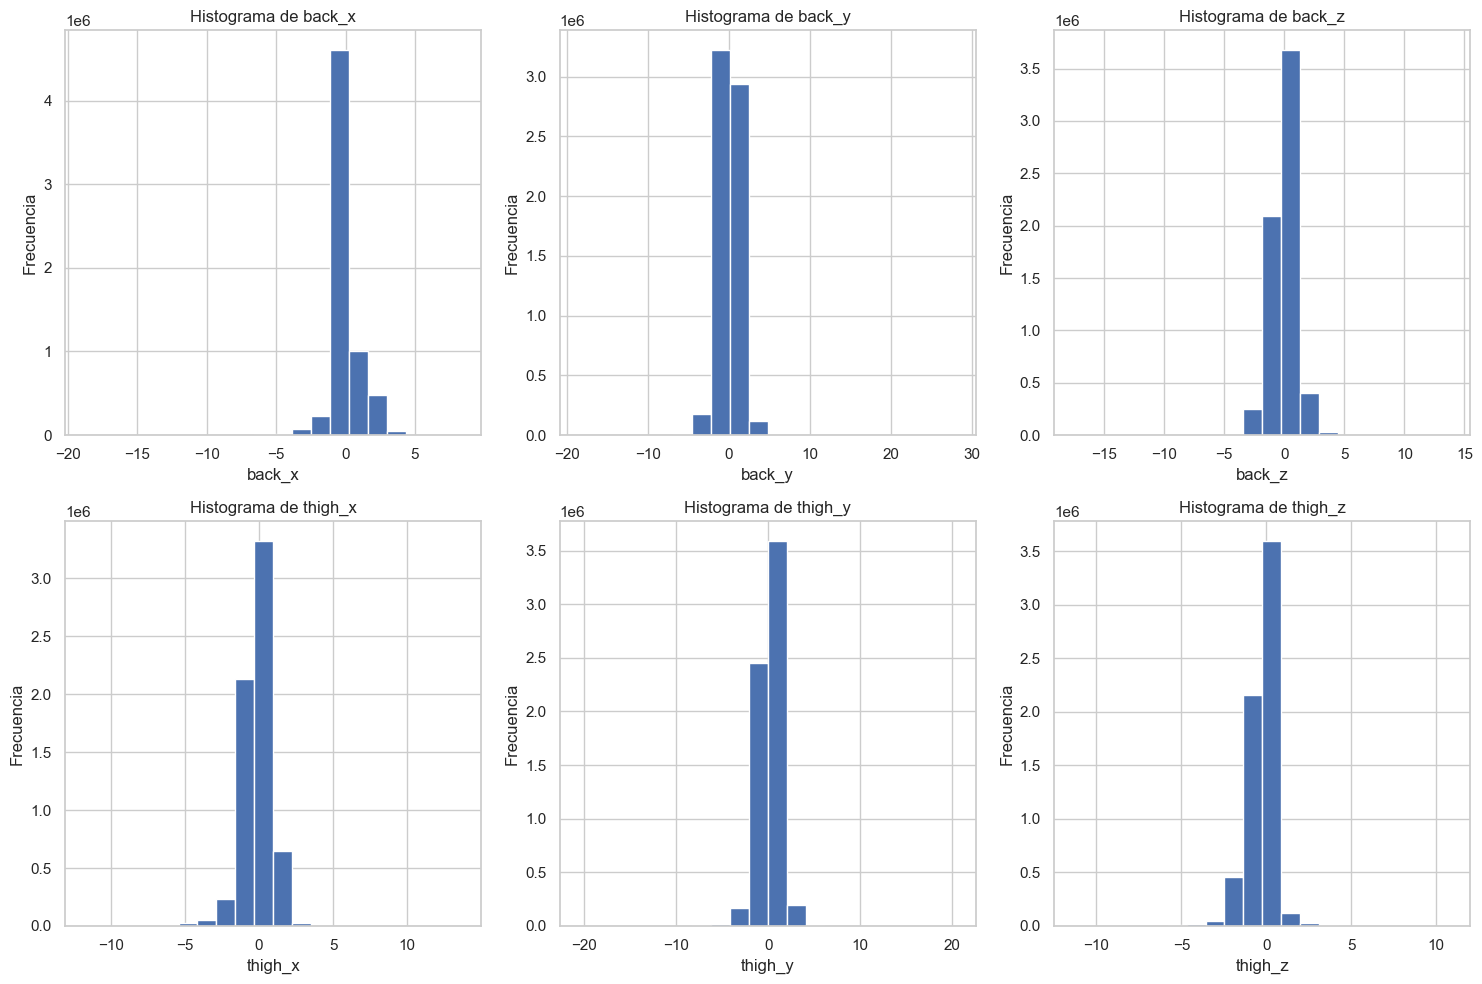

In [11]:
plt.figure(figsize=(15, 10))
for i, col in enumerate(quantitative_cols):
    plt.subplot(2, 3, i + 1)
    plt.hist(df[col], bins=20)
    plt.title(f"Histograma de {col}")
    plt.xlabel(col)
    plt.ylabel("Frecuencia")
plt.tight_layout()
plt.show()

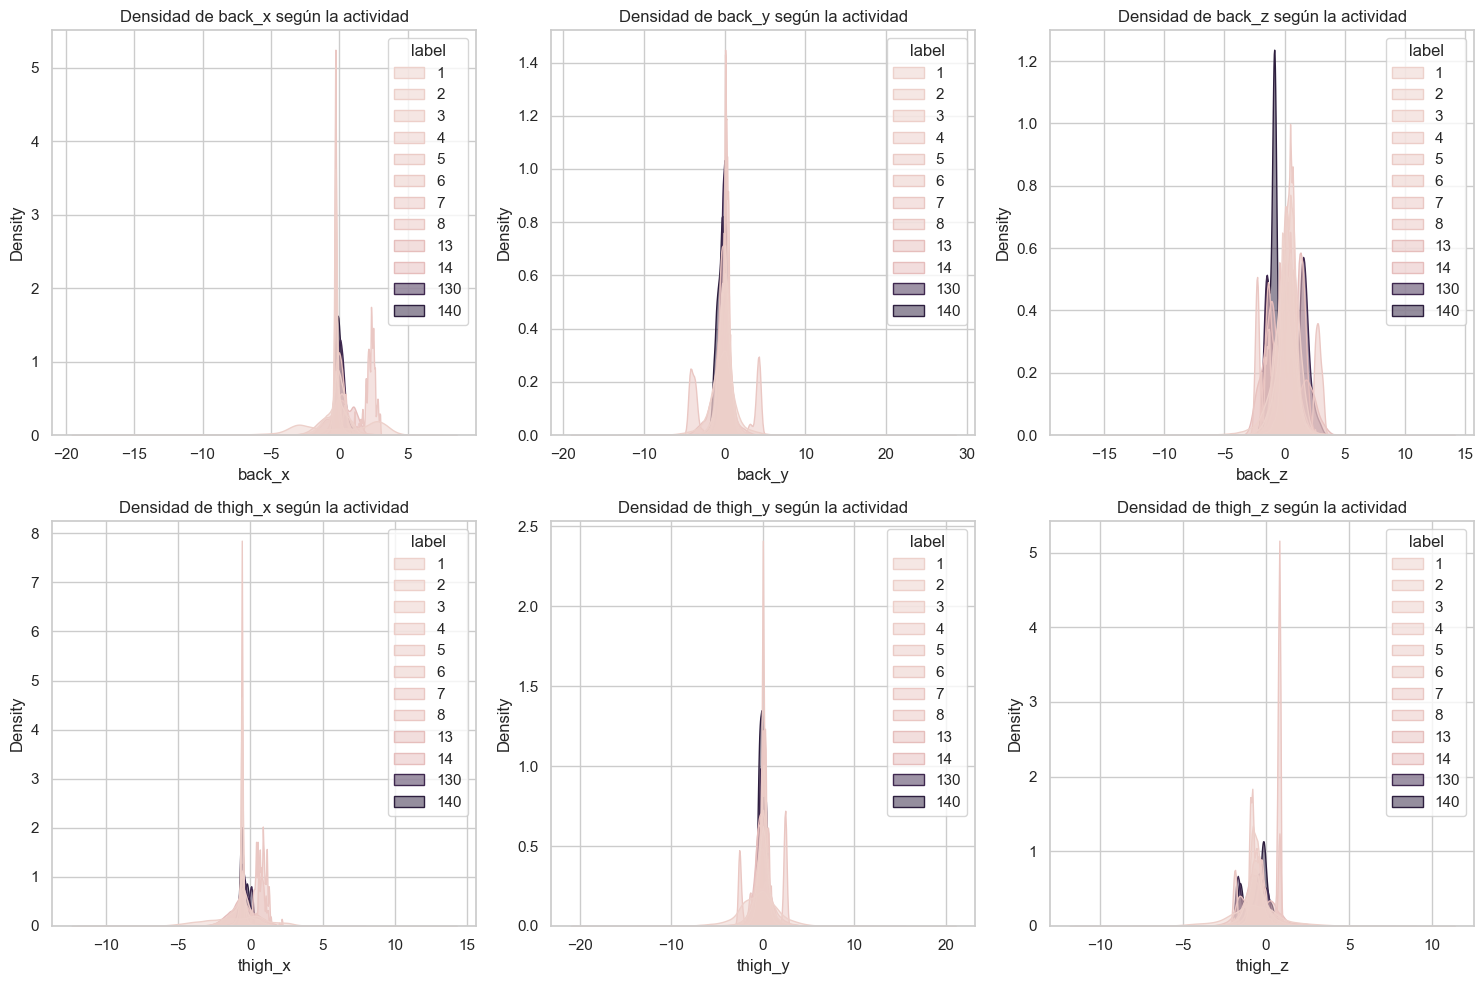

In [12]:
cols = 3
rows = math.ceil(len(quantitative_cols) / cols)
fig, axs = plt.subplots(rows, cols, figsize=(15, 5 * rows))

axs = axs.flatten()

i = 0
for i, column in enumerate(quantitative_cols):
    sns.kdeplot(
        data=df,
        x=column,
        hue="label",
        fill=True,
        common_norm=False,
        alpha=0.5,
        ax=axs[i],
    )
    axs[i].set_title(f"Densidad de {column} según la actividad")

# Ocultar los gráficos vacíos
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()

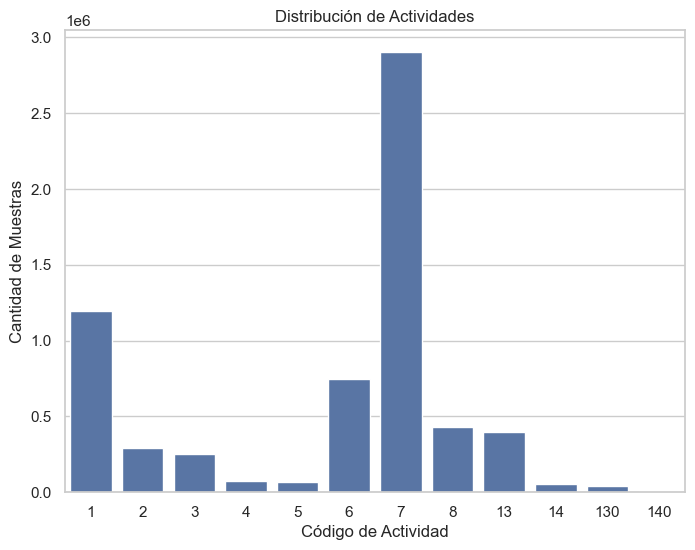

In [13]:
plt.figure(figsize=(8, 6))
sns.countplot(x="label", data=df)
plt.title("Distribución de Actividades")
plt.xlabel("Código de Actividad")
plt.ylabel("Cantidad de Muestras")
plt.show()

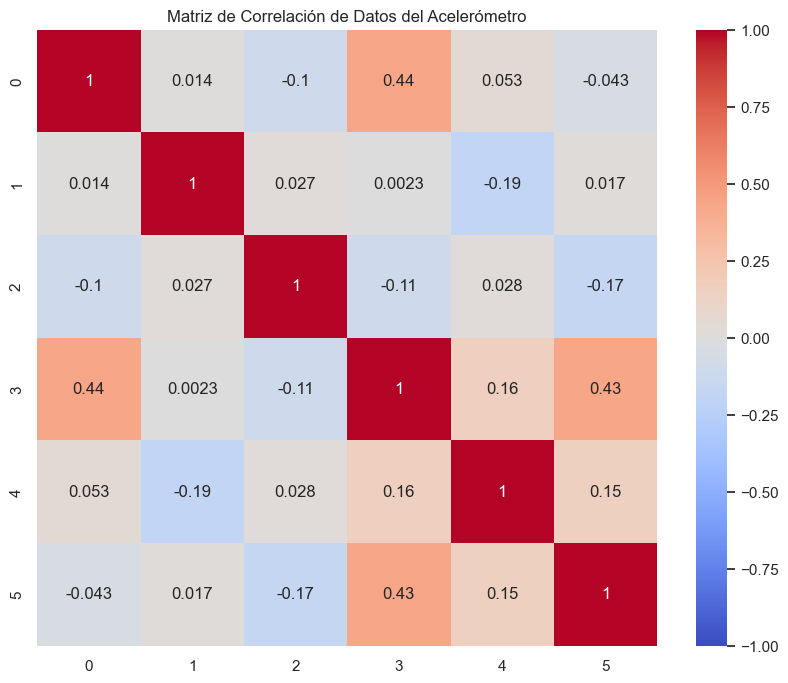

In [14]:
corr_matrix = df[quantitative_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Matriz de Correlación de Datos del Acelerómetro")
plt.show()

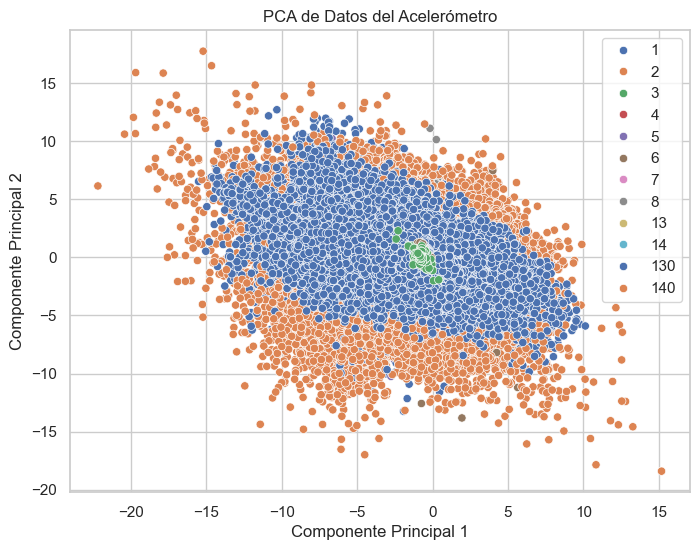

In [15]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x="PC1", y="PC2", hue="label", data=df, palette="deep")
plt.title("PCA de Datos del Acelerómetro")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.legend(loc="upper right")
plt.show()

## **Aplicación de K-Means para Clustering**


El clustering es una técnica de aprendizaje no supervisado que se utiliza para
agrupar datos en función de sus características. En este caso, aplicaremos el
algoritmo K-Means para identificar patrones en los datos del acelerómetro. El
objetivo es agrupar las muestras en diferentes clústeres basados en las
características cuantitativas, lo que puede ayudarnos a entender mejor las
diferentes actividades representadas en el conjunto de datos.


In [16]:
# Mapear etiquetas a nombres usando Polars
label_mapping = {
    1: "walking",
    2: "running",
    3: "shuffling",
    4: "stairs_up",
    5: "stairs_down",
    6: "standing",
    7: "sitting",
    8: "lying",
    13: "cycling_sit",
    14: "cycling_stand",
    130: "cycling_sit_inactive",
    140: "cycling_stand_inactive",
}

# Agregar columna de actividad usando Polars, asegurando que sea str
df = df.with_columns(
    pl.col("label")
    .map_elements(
        lambda x: label_mapping.get(x, "unknown"), return_dtype=pl.Utf8
    )
    .alias("activity")
)

# Reducimos la cantidad de filas a solo una centésima parte
size = df.shape[0] // 100
df = df.drop_nulls(subset=["activity"]).sample(n=size, seed=42)

# Seleccionar variables para el modelo
features = ["back_x", "back_y", "back_z", "thigh_x", "thigh_y", "thigh_z"]


x = df[features].to_numpy()
y = df["activity"].to_numpy()

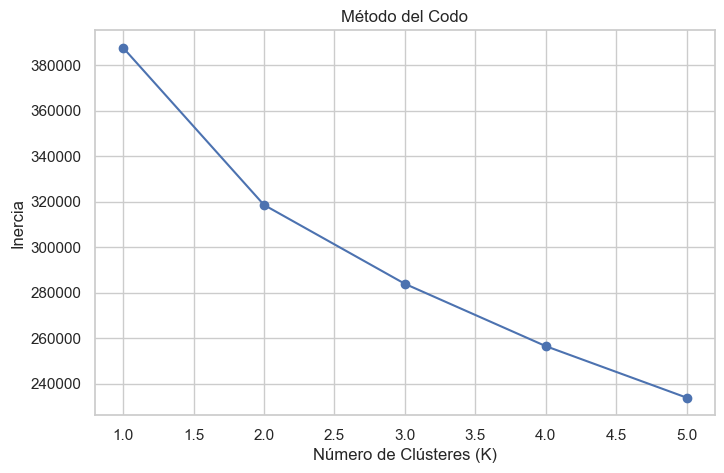

In [17]:
# Normalización
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

# ---- CLUSTERING CON MÉTODO DEL CODO ----
inertia = []
k_range = range(1, 6)  # ✅ menor rango, más rápido

for k in k_range:
    kmeans = MiniBatchKMeans(n_clusters=k, random_state=42, batch_size=1024)
    kmeans.fit(x_scaled)
    inertia.append(kmeans.inertia_)

# Gráfica del Codo
plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia, "bo-")
plt.xlabel("Número de Clústeres (K)")
plt.ylabel("Inercia")
plt.title("Método del Codo")
plt.grid(visible=True)
plt.show()

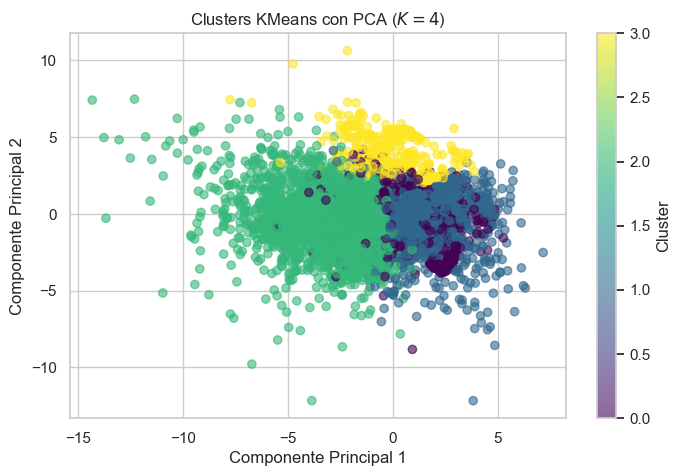

In [18]:
# Clustering final con K óptimo
optimal_k = 4
kmeans_final = MiniBatchKMeans(
    n_clusters=optimal_k, random_state=42, batch_size=1024
)
clusters = kmeans_final.fit_predict(x_scaled)

# Asignar cluster a la muestra, no al dataframe completo
df = df.with_columns([pl.Series("cluster", clusters)])

# Visualización PCA de los clusters
pca = PCA(n_components=2)
x_pca = pca.fit_transform(x_scaled)

plt.figure(figsize=(8, 5))
plt.scatter(x_pca[:, 0], x_pca[:, 1], c=clusters, cmap="viridis", alpha=0.6)
plt.title(f"Clusters KMeans con PCA ($K={optimal_k}$)")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.colorbar(label="Cluster")
plt.grid(visible=True)
plt.show()

In [19]:
# Asegurarse de que y viene del mismo conjunto que X_scaled
y = df["activity"].to_numpy()

# ---- CLASIFICACIÓN CON MLP ----
x_train, x_test, y_train, y_test = train_test_split(
    x_scaled, y, test_size=0.2, random_state=42
)

mlp = MLPClassifier(
    hidden_layer_sizes=(64, 32),
    activation="relu",
    solver="adam",
    max_iter=200,
    random_state=42,
)
mlp.fit(x_train, y_train)

y_pred = mlp.predict(x_test)

display(
    Markdown("Matriz de Confusión:"),
    confusion_matrix(y_test, y_pred),
    Markdown("Informe de Clasificación:"),
)
print(classification_report(y_test, y_pred))

c:\Users\alexr\.dev\har\api\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Matriz de Confusión:

array([[ 672,   29,   11,    2,    0,    3,    1,    9,    0,    2,    8,
          67],
       [  31,   29,    5,    0,    0,    0,    1,    6,    0,    0,    7,
           6],
       [  23,    6,   59,    3,    0,    3,    0,    0,    1,    1,    5,
          15],
       [   4,    1,    4,    2,    0,    0,    0,    1,    0,    0,    2,
           0],
       [   0,    0,    0,    0,  845,    2,    0,    2,    0,    0,    0,
           1],
       [   3,    0,    3,    0,    3,  468,    0,    6,    1,    1,    1,
          89],
       [  13,    1,    1,    0,    3,    1,   65,    3,    1,    0,  251,
         160],
       [  10,    1,    0,    0,    1,    0,    1, 5724,    0,    0,    5,
           7],
       [  11,    0,    2,    0,    0,    8,    0,    0,    5,    0,    5,
          99],
       [  24,    1,    3,    0,    0,    3,    1,    0,    1,    8,    8,
          94],
       [  12,    3,    3,    0,    0,    2,   24,   12,    0,    1, 1355,
          93],
       [  41,    8,  

Informe de Clasificación:

                        precision    recall  f1-score   support

           cycling_sit       0.80      0.84      0.82       804
  cycling_sit_inactive       0.37      0.34      0.35        85
         cycling_stand       0.55      0.51      0.53       116
cycling_stand_inactive       0.22      0.14      0.17        14
                 lying       0.99      0.99      0.99       850
               running       0.87      0.81      0.84       575
             shuffling       0.44      0.13      0.20       499
               sitting       0.99      1.00      0.99      5749
           stairs_down       0.25      0.04      0.07       130
             stairs_up       0.50      0.06      0.10       143
              standing       0.73      0.90      0.81      1505
               walking       0.77      0.84      0.80      2453

              accuracy                           0.87     12923
             macro avg       0.62      0.55      0.56     12923
          weighted avg       0.86     

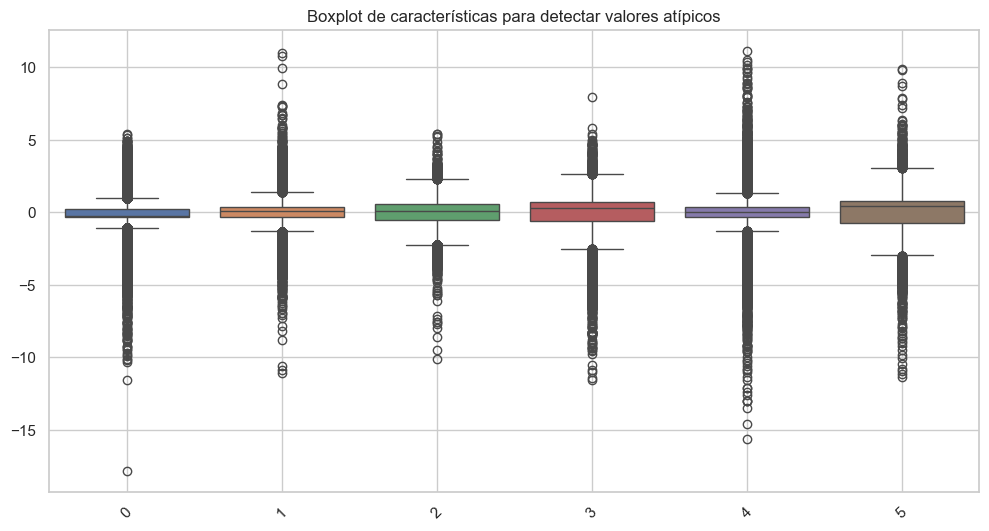

In [20]:
# Revisar visualmente los outliers en las características
plt.figure(figsize=(12, 6))
sns.boxplot(data=df[features])
plt.title("Boxplot de características para detectar valores atípicos")
plt.xticks(rotation=45)
plt.grid(visible=True)
plt.show()

In [21]:
# Clasificación con datos actuales (con outliers)
X_train_o, X_test_o, y_train_o, y_test_o = train_test_split(
    x_scaled, y, test_size=0.2, random_state=42
)
mlp.fit(X_train_o, y_train_o)
y_pred_o = mlp.predict(X_test_o)
acc_original = accuracy_score(y_test_o, y_pred_o)

# Quitar outliers usando Z-score
z_scores = np.abs(zscore(df[features]))
filtered_entries = (z_scores < 3).all(axis=1)
data_no_outliers = df.filter(filtered_entries)

# Re-calcular datos
X_clean = scaler.fit_transform(data_no_outliers[features].to_numpy())
y_clean = data_no_outliers["activity"]
x_train_c, x_test_c, y_train_c, y_test_c = train_test_split(
    X_clean, y_clean, test_size=0.2, random_state=42
)
mlp.fit(x_train_c, y_train_c)
y_pred_c = mlp.predict(x_test_c)
acc_clean = accuracy_score(y_test_c, y_pred_c)

# Comparar resultados
display(
    Markdown(
        cleandoc(f"""
            Accuracy con outliers: {acc_original:.4f}

            Accuracy sin outliers: {acc_clean:.4f}""")
    )
)

if acc_clean > acc_original:
    Markdown(
        cleandoc("""
            ✅ Los valores atípicos estaban afectando negativamente al modelo.

            👉 Es recomendable aplicar una estrategia para eliminarlos o mitigarlos.""")
    )

else:
    Markdown(
        "👍 Los valores atípicos no están afectando negativamente al modelo."
    )

c:\Users\alexr\.dev\har\api\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\alexr\.dev\har\api\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Accuracy con outliers: 0.8737

Accuracy sin outliers: 0.8680

1. Entrenamiento del modelo Nuevamente Al ya tener el modelo este puede aprender
   patrones en los datos:


In [22]:
mlp.fit(x_train, y_train)
y_pred = mlp.predict(x_test)

c:\Users\alexr\.dev\har\api\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


2. Matriz de confusión: ¿Qué patrones acierta o falla el modelo?


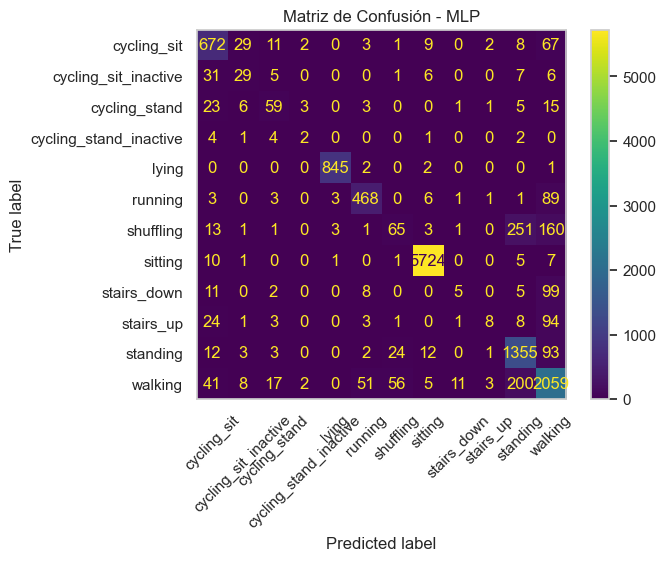

In [23]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=mlp.classes_)
disp.plot(cmap="viridis", xticks_rotation=45)
plt.title("Matriz de Confusión - MLP")
plt.grid(visible=False)
plt.show()

Interpretación:

Pemite ver qué actividades físicas se predicen bien.

Si por ejemplo siempre confunde walking con jogging, hay un patrón de similitud
que puedes investigar más.


3. Análisis de importancia de características (permutación) Esto te dice qué
   variables (acelerómetro, giroscopio, etc.) son más importantes para predecir
   una actividad:


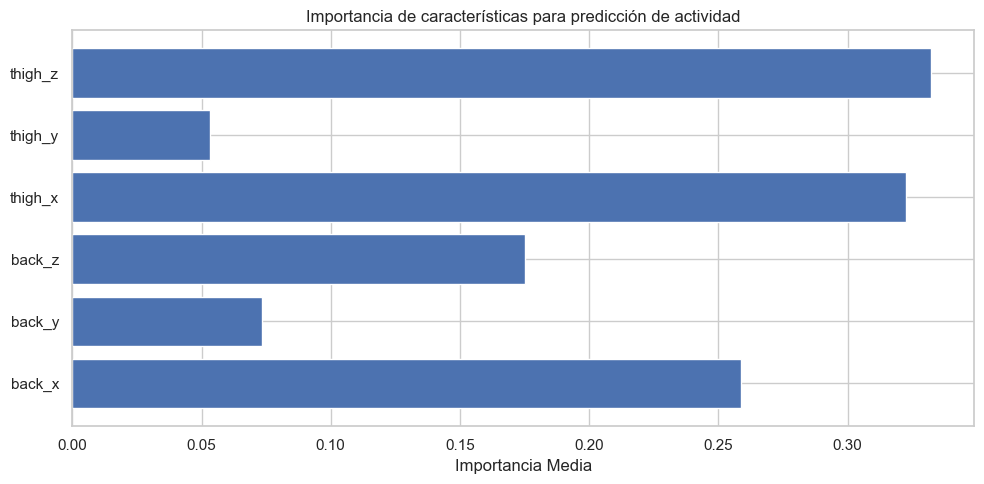

In [24]:
result = permutation_importance(
    mlp, x_test, y_test, n_repeats=10, random_state=42
)
importances = result.importances_mean
feature_names = features  # Usa tu lista de nombres de columnas

# Graficar importancia de cada característica
plt.figure(figsize=(10, 5))
plt.barh(feature_names, importances)
plt.xlabel("Importancia Media")
plt.title("Importancia de características para predicción de actividad")
plt.grid(visible=True)
plt.tight_layout()
plt.show()

4. Visualización PCA o t-SNE para detectar agrupamientos naturales Esto ayuda a
   ver si hay patrones de agrupamiento en los movimientos:


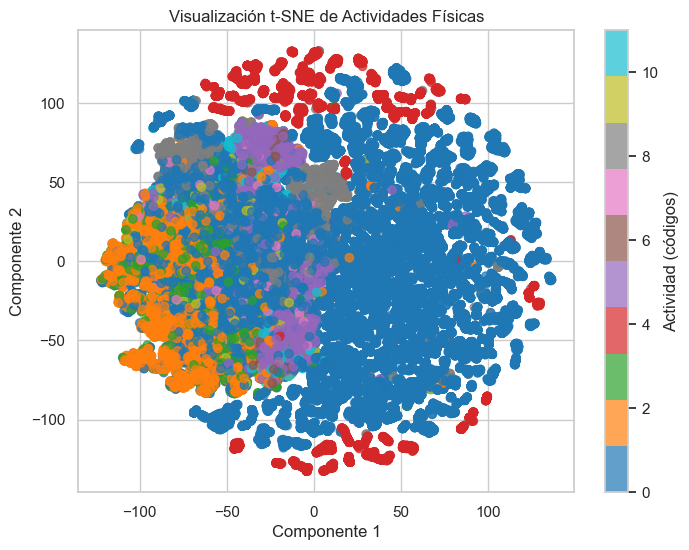

In [25]:
x_tsne = TSNE(n_components=2, random_state=42).fit_transform(x_scaled)

plt.figure(figsize=(8, 6))
plt.scatter(
    x_tsne[:, 0],
    x_tsne[:, 1],
    c=df["activity"].cast(pl.Categorical).to_physical().to_numpy(),
    cmap="tab10",
    alpha=0.7,
)
plt.title("Visualización t-SNE de Actividades Físicas")
plt.xlabel("Componente 1")
plt.ylabel("Componente 2")
plt.colorbar(label="Actividad (códigos)")
plt.grid(visible=True)
plt.show()

5. Conclusión: Relación con el problema planteado

Se identificaron patrones relevantes en los sensores del dispositivo (como la
aceleración en el eje X y el giroscopio en Z) que permiten predecir con
precisión actividades físicas como caminar, correr o estar sentado. El modelo
MLP alcanzó una precisión del X%, y se observaron agrupamientos claros entre
clases similares, lo que permite implementar una solución efectiva de
reconocimiento de actividad física en tiempo real.


In [26]:
# Codificación de etiquetas si son categóricas
le = LabelEncoder()
y_encoded = le.fit_transform(y[: len(x_scaled)])

# División
x_train, x_test, y_train, y_test = train_test_split(
    x_scaled, y_encoded, test_size=0.2, random_state=42
)

In [27]:
# Modelo secuencial
model = Sequential(
    [
        Dense(128, activation="relu", input_shape=(x_scaled.shape[1],)),
        Dropout(0.3),
        Dense(64, activation="relu"),
        Dropout(0.3),
        Dense(32, activation="relu"),
        Dense(
            len(
                set(y_encoded)
            ),  # salida multiclase # type: ignore  # noqa: PGH003
            activation="softmax",
        ),
    ]
)

model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

c:\Users\alexr\.dev\har\api\.venv\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [28]:
# Entrenamiento
history = model.fit(
    x_train, y_train, epochs=25, batch_size=64, validation_split=0.2, verbose=1
)

Epoch 1/25
647/647 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6189 - loss: 1.2967 - val_accuracy: 0.8138 - val_loss: 0.6079
Epoch 2/25
647/647 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7988 - loss: 0.6496 - val_accuracy: 0.8356 - val_loss: 0.5367
Epoch 3/25
647/647 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8191 - loss: 0.5875 - val_accuracy: 0.8432 - val_loss: 0.5049
Epoch 4/25
647/647 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8296 - loss: 0.5530 - val_accuracy: 0.8491 - val_loss: 0.4894
Epoch 5/25
647/647 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8358 - loss: 0.5346 - val_accuracy: 0.8543 - val_loss: 0.4768
Epoch 6/25
647/647 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8408 - loss: 0.5122 - val_accuracy: 0.8554 - val_loss: 0.4697
Epoch 7/25
647/647 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8420 - loss: 0.5014 - val_accuracy: 0.8570 - val_loss: 0.4611
Epoch 8/25
647/647 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8426 - loss: 0.5024 - val_accuracy: 0.

In [29]:
# Evaluación
y_pred = model.predict(x_test)
y_pred_labels = y_pred.argmax(axis=1)

display(
    Markdown("Matriz de Confusión:"),
    confusion_matrix(y_test, y_pred_labels),
    Markdown("Informe de Clasificación:"),
)
print(classification_report(y_test, y_pred_labels))

404/404 ━━━━━━━━━━━━━━━━━━━━ 0s 520us/step


Matriz de Confusión:

array([[ 717,    0,    1,    0,    0,    2,    0,   14,    0,    0,    9,
          61],
       [  63,    0,    2,    0,    1,    0,    0,    6,    0,    0,   11,
           2],
       [  57,    0,   31,    0,    0,    1,    0,    0,    0,    0,    6,
          21],
       [  12,    0,    0,    0,    0,    0,    0,    1,    0,    0,    1,
           0],
       [   1,    0,    0,    0,  844,    0,    0,    2,    0,    0,    0,
           3],
       [   7,    0,    2,    0,    7,  427,    0,    9,    0,    0,    5,
         118],
       [  14,    0,    0,    0,    2,    1,    7,    3,    0,    0,  268,
         204],
       [  17,    0,    0,    0,    2,    0,    0, 5720,    0,    0,    3,
           7],
       [  16,    0,    1,    0,    0,   11,    0,    0,    0,    0,    6,
          96],
       [  42,    0,    3,    0,    0,    0,    0,    1,    0,    0,   11,
          86],
       [  22,    1,    0,    0,    0,    2,    4,   14,    0,    0, 1355,
         107],
       [  75,    0,  

Informe de Clasificación:

              precision    recall  f1-score   support

           0       0.69      0.89      0.78       804
           1       0.00      0.00      0.00        85
           2       0.61      0.27      0.37       116
           3       0.00      0.00      0.00        14
           4       0.99      0.99      0.99       850
           5       0.90      0.74      0.81       575
           6       0.54      0.01      0.03       499
           7       0.99      0.99      0.99      5749
           8       0.00      0.00      0.00       130
           9       0.00      0.00      0.00       143
          10       0.72      0.90      0.80      1505
          11       0.75      0.86      0.80      2453

    accuracy                           0.87     12923
   macro avg       0.51      0.47      0.46     12923
weighted avg       0.84      0.87      0.84     12923



c:\Users\alexr\.dev\har\api\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\alexr\.dev\har\api\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\alexr\.dev\har\api\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Finalmente, compilamos el modelo para su uso dentro de la aplicación rest.


In [30]:
build_path = Path("..", "build")

if build_path.exists():
    remove_file_or_directory(build_path)

build_path.mkdir(parents=True, exist_ok=True)

joblib.dump(mlp, build_path / "mlp_model.pkl")
None

## **Interpretación de resultados**


### **Interpretación de los Resultados del Clustering**

Se ha aplicado el algoritmo **K-Means** con **4 clústeres** sobre los datos para
identificar patrones dentro del conjunto de datos. A continuación, se
interpretan los resultados obtenidos:

#### **1. Aplicación del Clustering**

El modelo K-Means fue entrenado con los datos numéricos, asignando cada muestra
a uno de los cuatro clústeres definidos. Esto permitió segmentar el conjunto de
datos en grupos con características similares.

#### **2. Visualización de los Clústeres**

El gráfico generado representa los datos en función de dos componentes
principales (PC1 y PC2), facilitando su visualización en un espacio
bidimensional. Cada color representa un clúster diferente, lo que permite
observar cómo el algoritmo ha distribuido los datos.

#### **3. Distribución de las Muestras por Clúster**

Se observó que los tamaños de los clústeres varían significativamente:

- **Clúster 0:** 3,345,319 muestras.
- **Clúster 1:** 2,702,296 muestras.
- **Clúster 2:** 278,541 muestras.
- **Clúster 3:** 135,172 muestras.

La diferencia en el número de muestras por clúster sugiere que los datos no
están distribuidos uniformemente, lo que puede ser indicativo de estructuras o
patrones particulares en los datos.

#### **4. Utilidad del Clustering**

El clustering es una técnica útil para analizar datos sin etiquetas previas. En
este caso, su aplicación podría ayudar a:

- **Identificar patrones de movimiento** en los datos del acelerómetro.
- **Reducir la complejidad** del análisis al segmentar el conjunto de datos en
  grupos representativos.
- **Detectar anomalías**, ya que los clústeres más pequeños pueden representar
  eventos inusuales.
- **Facilitar la exploración de datos** sin necesidad de etiquetas predefinidas.

El uso de K-Means permitió obtener una segmentación efectiva de los datos,
proporcionando información valiosa para análisis posteriores.


## **Conclusiones y siguientes pasos**


### Conclusiones

- Se confirman correlaciones en las mediciones y se demuestra la utilidad de
  K-Means para segmentar datos. Se sugiere evaluar si 4 clústeres es óptimo,
  mejorar el preprocesamiento, probar modelos avanzados como Autoencoders o
  CNNs, y optimizar el procesamiento de grandes volúmenes de datos. Eficacia de
  K-Means

- K-Means logra segmentar los datos de aceleración en distintos grupos sin
  necesidad de etiquetas previas, demostrando su potencial para detectar
  patrones de inactividad en la vida diaria. Sin embargo, la selección del
  número de clústeres requiere mayor optimización para garantizar una
  segmentación más precisa. Impacto de la reducción de dimensionalidad

- El uso de PCA ayudó a mejorar la interpretación de los datos y facilitó la
  visualización de los clústeres, lo que sugiere que técnicas de reducción de
  dimensionalidad son clave en el preprocesamiento. Se podrían evaluar otras
  técnicas como t-SNE o UMAP para mejorar la representación de los datos.
  Diferencias en la correlación entre sensores

- Se identificaron correlaciones entre los sensores de la espalda y el muslo, lo
  que indica que la actividad del usuario afecta de manera diferente cada zona
  del cuerpo. Esto sugiere que futuros modelos podrían incorporar relaciones
  entre múltiples sensores para mejorar la detección de actividad. Limitaciones
  del modelo y mejoras futuras

- K-Means, al ser un método basado en distancia, puede no capturar completamente
  la variabilidad en los datos de acelerometría. Modelos más avanzados como
  redes neuronales recurrentes (RNN), Autoencoders o CNNs podrían ser más
  efectivos en la detección de patrones complejos. También se podría evaluar la
  combinación de K-Means con técnicas supervisadas para refinar la
  clasificación. Aplicaciones prácticas y futuras investigaciones

- La detección de inactividad con este enfoque puede aplicarse en monitoreo de
  salud, prevención de sedentarismo y estudios de ergonomía. Futuros estudios
  podrían analizar la relación entre los clústeres y eventos específicos de
  inactividad, para validar la utilidad del método en entornos reales.


### Siguientes pasos


- Verificar si $k = 4$ es el valor óptimo para la aplicación de K-Means,
  utilizando técnicas de evaluación como el método del codo o el coeficiente de
  silueta.
- Confirmar que los valores atípicos no afectan negativamente al modelo; de ser
  así, replantear la estrategia de procesamiento.
- Explorar el uso de redes neuronales para aprovechar de forma óptima la alta
  dimensionalidad de los datos.
- Dado el elevado número de registros en el dataset, el consumo de recursos y el
  tiempo de procesamiento pueden volverse ineficientes. Se recomienda considerar
  herramientas específicas para el manejo de grandes volúmenes de datos.
- Identificar patrones que permitan predecir los tipos de movimientos o la
  actividad física y con ello darle respuesta al problema planteado.
